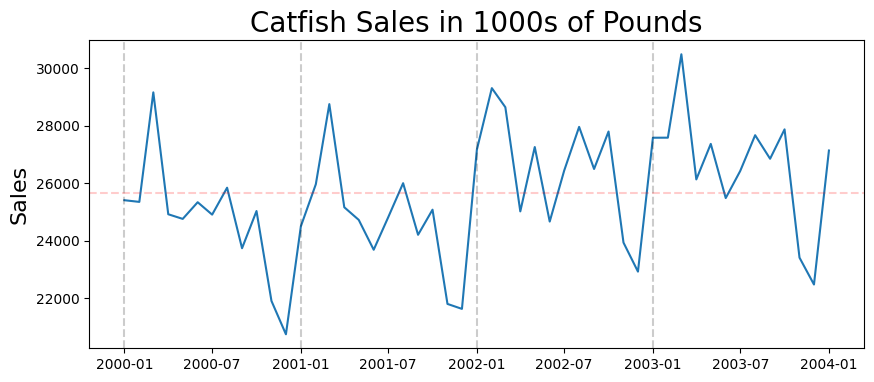

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time


catfish_sales = pd.read_csv(os.path.join(os.getcwd(), 'data/catfish.csv'), 
                             parse_dates=[0], index_col=0) # parse_dates = [0] indicates that we are treating the first column of our data as date. index_col = 0 means we are indexing our data using the first col

# Convert the index to datetime format if needed
catfish_sales.index = pd.to_datetime(catfish_sales.index)
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

# Take subset of data
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1) #yyyy-dd-mm
lim_catfish_sales = catfish_sales[start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.astype(float).mean().item(), color='r', alpha=0.2, linestyle='--') # converts lim_catfish_sales from object to float, convert calculated mean series to scalar using .item()


Data exhibits seasonal/uptrend characteristic: Take first difference to ensure stationality

In [4]:
first_diff = lim_catfish_sales.diff()[1:] # Slice from point 2 onwards since first difference has 1 less datapoint

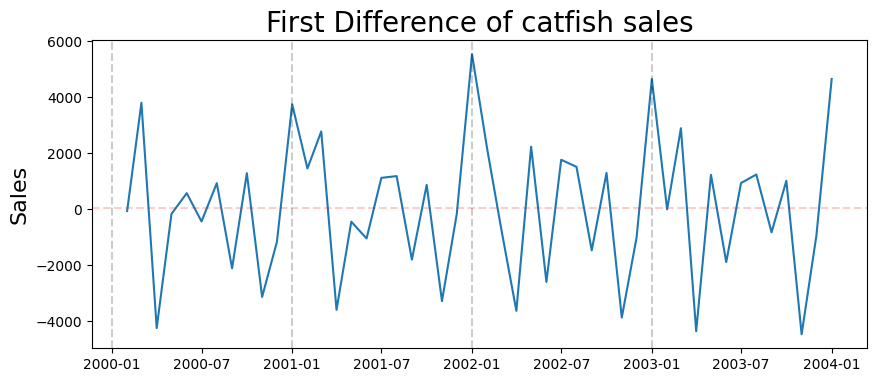

In [5]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of catfish sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.astype(float).mean().item(), color='r', alpha=0.2, linestyle='--') # converts lim_catfish_sales from object to float, convert calculated mean series to scalar using .item()


### ACF

<BarContainer object of 15 artists>

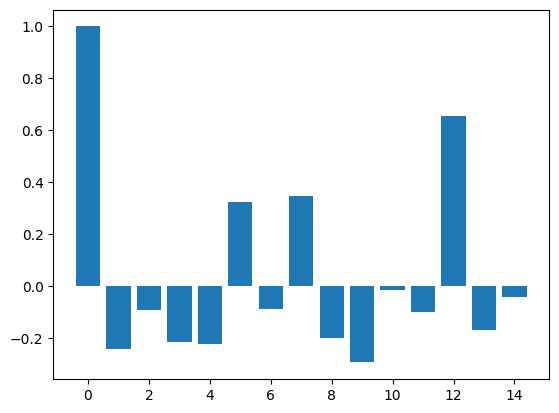

In [8]:
acf_vals = acf(first_diff)
num_lags = 15
plt.bar(range(num_lags), acf_vals[:num_lags])

### PACF

<BarContainer object of 15 artists>

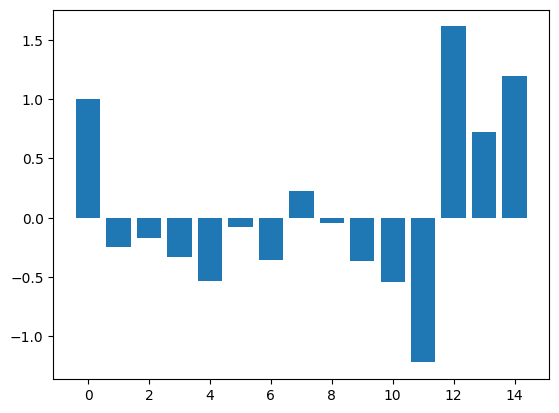

In [9]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

#### Based on ACF & PACF plot, we are going to go with MA(1) + AR(4)

### Fitting ARMA model

In [10]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

In [11]:
model = ARIMA(train_data, order=(4, 0, 1)) # order=(no. of lags, no of differencing(stationality), MA: uses one lag of the forecast errors)
model_fit = model.fit()

#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -376.598
Date:                Thu, 31 Oct 2024   AIC                            767.195
Time:                        16:35:00   BIC                            779.359
Sample:                    02-01-2000   HQIC                           771.654
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1795    179.935      0.134      0.893    -328.487     376.847
ar.L1         -0.8659      0.222     -3.896      0.000      -1.302      -0.430
ar.L2         -0.4234      0.246     -1.724      0.0

### Prediction

In [19]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.Total - predictions

Root Mean Squared Error: 2214.6996926417537


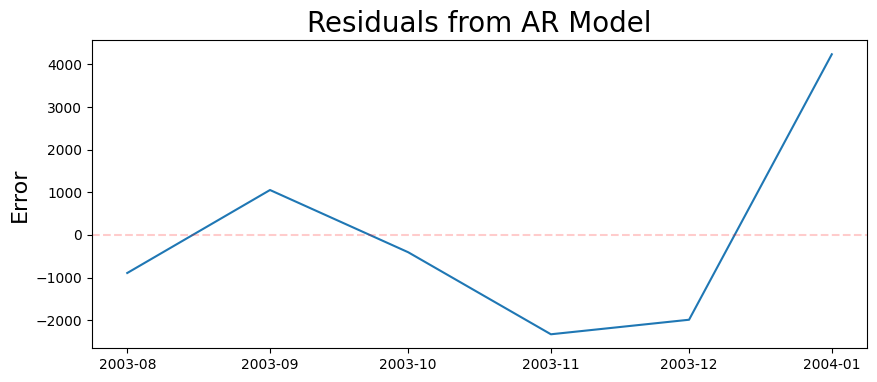

In [20]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


Text(0, 0.5, 'Sales')

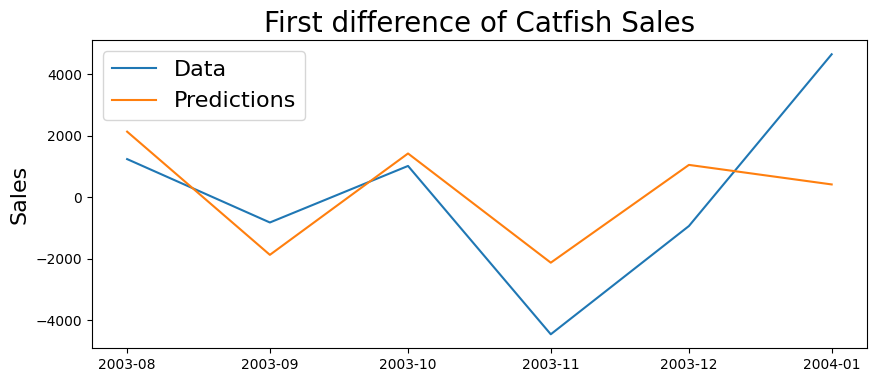

In [22]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [23]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2214.6996926417537
